<div class="alert alert-info">
<strong>Authors:</strong> Oxoli Daniele, Capizzi Emanuele - 2022 - Politecnico di Milano <br>
<strong>License:</strong> MIT
</div>

<div class="alert alert-block alert-success">
<h1>Create a personalized dashboard for requesting data using WEkEO HDA API and add interactive widgets for data analysis</h1></div>

# NOTEBOOK INTRODUCTION

### Data used in this example

| Product Description | Link | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-----------------:|:-----------------:|
| ERA5 - Single Levels | <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview" target="_blank">link</a> | EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AERA5_HOURLY_VARIABLES_ON_PRESSURE_LEVELS" target="_blank">link</a> |
|CAMS - European Air Quality Forecasts|<a href="https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview" target="_blank">link</a>|EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3ACAMS_EUROPE_AIR_QUALITY_FORECASTS" target="_blank">link</a>|
|CEMS - River discharge and related historical data from the European Flood Awareness System|<a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/efas-historical?tab=overview" target="_blank">link</a>|EO:ECMWF:DAT:EFAS_HISTORICAL|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AEFAS_HISTORICAL" target="_blank">link</a>|
|CMEMS - Atlantic- European North West Shelf- Ocean Physics Reanalysis|<a href="https://resources.marine.copernicus.eu/product-detail/NWSHELF_MULTIYEAR_PHY_004_009/INFORMATION" target="_blank">link</a>|EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m|<a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AMO%3ADAT%3ANWSHELF_ANALYSISFORECAST_PHY_LR_004_001" target="_blank">link</a>|

### Learning outcomes

At the end of this notebook you will know:
* How to access [*<span style='color:Blue'>WEkEO</span>*](https://www.wekeo.eu/) datasets using [*<span style='color:Blue'>HDA API</span>*](https://www.wekeo.eu/docs/harmonised-data-access-api) and the [*<span style='color:Blue'>requests</span>*](https://requests.readthedocs.io/en/latest/) Python library;
* How to create a simple dashboard using Jupyter Notebooks widgets. They are provided by the [*<span style='color:Blue'>Ipywidgets</span>*](https://ipywidgets.readthedocs.io/en/latest/) library and can be useful to automatize data access directly from your Jupyter Notebook
* How to use `GET` and `POST` requests to get data from HDA API.

https://github.com/ecmwf-projects/copernicus-training/blob/master/CAMS_European-air-quality-index.ipynb


### Outline

This notebook aims to show how to create simple interactive dashboards for downloading data from WEkEO DIAS. The purpose is to show and create blocks of code that can be reused for other available datasets.

API endpoints are available at the following link: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/ui/#/

The example code can be adapted according to the metadata of the requested resource. The links for requesting the data can be retrieved from [*<span style='color:Blue'>Swagger UI</span>*](https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/ui/#!/HDA_-_dataorder/dataorder_get)  (improve description).

![broker.jpeg](images/broker.jpg)

SHORT DESCRIPTION OF IPYWIDGETS 

References: 
 - https://www.youtube.com/watch?v=sAI7Se1aCRM&t=2405s
 - https://github.com/ecmwf-projects/copernicus-training

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Login section](#login)   
 2. [Datasets exploration](#exploration) 
 3. [Section 1 - ERA5 Reanalysis Single Levels](#section1)
 4. [Section 2 - CAMS - Europe Air Quality Forecasts](#section2)
 5. [Section 3 - CMEMS - Analysis/Forecast Sea Bottom Temperature](#section3)


<hr>

<div class="alert alert-info" role="alert">

## <a id='libraries'></a>Import libraries

</div>

In [ ]:
import requests
import json
import pandas as pd
import base64
import datetime
import ipywidgets as widgets
from ipywidgets import Layout
from PIL import Image
import numpy as np
import rioxarray as rxr
import xarray as xr
from IPython.display import display, JSON
import IPython
from IPython.display import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

# Import functions
import simplified_WEkEO_methods as m
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='login'></a> Logging to WEkEO DIAS using HDA API
[Back to top](#TOC_TOP)

</div>

The following widget allows to login with your WEkEO credentials and obtain the access token. It's necessary to run the code and insert the `Username` and `Password`:

<div class="alert alert-warning" role="alert">
<a id='warning'></a> For all widgets you just need to enter the information without running the code block again after you interacted.
</div>

In [ ]:
style= {'description_width': '150px'}
layout = {'width': '500px'}
username = widgets.Text(placeholder="Type WEkEO username",description="Insert username: ",style=style,layout=layout)
password = widgets.Password(placeholder="Type WEkEO password",description="Insert password: ",style=style,layout=layout)

login_box = widgets.VBox([username, password])
login_box

`Username` and `Password` are saved into the respective variables and they are used to retrieve a temporary access token using the following API endpoint:

It is also necessary to define a `headers` variable for the authorization.

In [ ]:
message = str(username.value+":"+password.value).encode('ascii')
base64_message = base64.b64encode(message).decode('ascii')
headers = {'authorization': 'Basic '+base64_message}
token_request = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/gettoken", headers=headers)
token_text = json.loads(token_request.text)
print("Your access token is: "+token_text['access_token'])
headers = {'authorization': token_text['access_token']}
token = list(headers.values())[0]

<div class="alert alert-warning" role="alert">
<a id='warning'></a> You may need to get a new access token if it expires. Just run the previous cell to get a new one.
</div>

<div class="alert alert-info" role="alert">

## <a id='exploration'></a> WEkEO Datasets exploration
[Back to top](#TOC_TOP)

</div>

First of all we are choose the `HDA IDs` for this notebook. Similarly to what was done previously, it is possible to access these data using the [*<span style='color:Blue'>requests </span>*](https://docs.python-requests.org/en/latest/) Python library to send the request to the API service. Finally, we can obtain a [*<span style='color:Blue'>Pandas</span>*](https://pandas.pydata.org/) dataframe containing all the datasets and their information available from WEkEO DIAS:

In [ ]:
size = 2000 # Max number of datasets to be requested (the total number is 1018)
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df # Show the first 5 datasets

Another option is to get the `dataset ID` manually from the WEkEO portal, instead of using the previous dataframe:

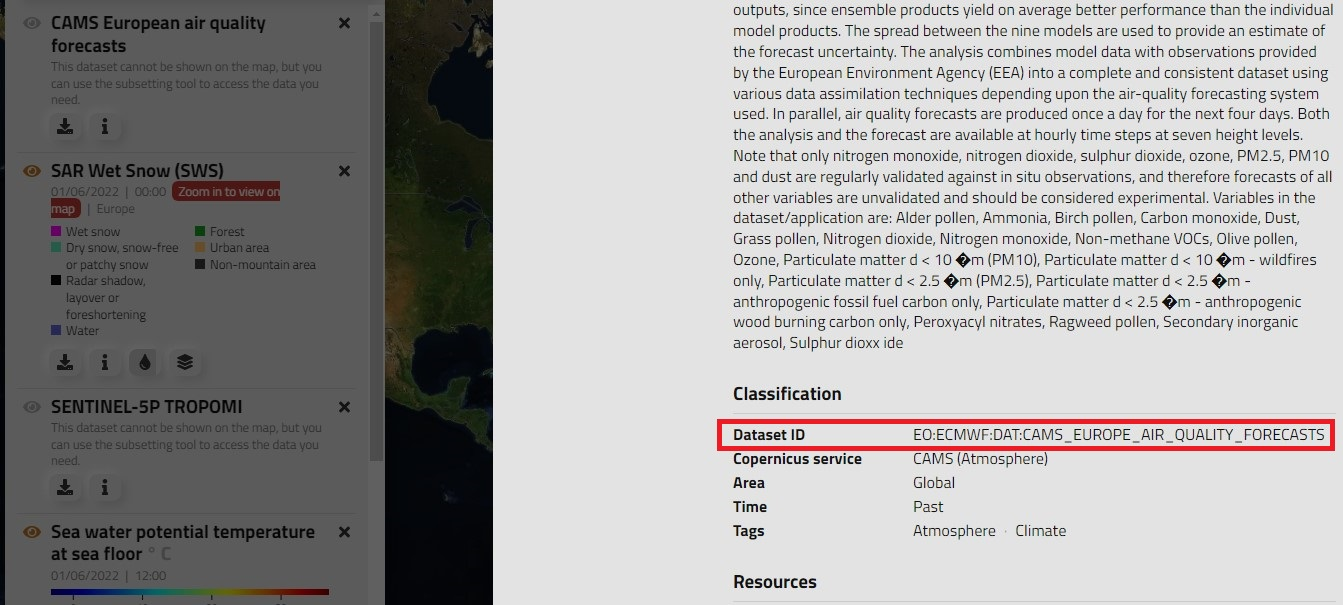

----

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Section 1 - ERA5 Reanalysis Single Levels
[Back to top](#TOC_TOP)

</div>

The first dataset used as example is the `ERA5 Reanalysis Single Levels`

In [ ]:
dataset_id = 'EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS'

Always using the request we saw in the previous chapter, we can filter the dataset we are interested in, the `ERA5 Reanalysis Single Levels` in this case:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

We now have information about:
 - `Abstract`
 - `HDA dataset ID` (in our case they are already saved it in the ds_list during the datasets exploration)
 - `Dataset preview image`
 - `Dataset title`

For example we can use the dataset `title`, `preview image` and the `abstract` to create a simple preview of the dataset. It can be useful to check if the dataset it's correct or to read its description:

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display image using IPython
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout( right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[1, 1.7, '100px'], grid_gap='50px')
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Moving forward the creation of the dashboard, it is possible to access the metadata for all the datasets with the following request:

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

We can interactively visualize the metadata using the display function for `IPython` library. This is very useful to understand how the metadata `JSON` file is structured and how it can be exploited to create the successive requests:

In [ ]:
display(JSON(metadata))

The ERA5 single level dataset contains many variables that can be selected. In this case we can obtain a list of variables containing all the `ERA5 Hourly Data On Single Levels` exploiting the metadata we obtained previously. Since the variables are stored with different labels, we can extract the keys with the following code (this may not be necessary for other datasets):

In [ ]:
category = metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels']
category_list = []
params_list = []
for item in category:
    category_list.append(item['valuesLabels'])

for item in category_list:
    key_list = list(item.keys())
    params_list.append(key_list)

variables_list = [item for sublist in params_list for item in sublist]
# variables_list   # Uncomment to show the variables list

Always keeping the metadata as reference, we can select the other necessary variables that will be used for generate the query used for the data request. For `ERA5 Hourly Data On Single Levels` we have to provide the following information:
 - `Format type`: e.g. netCDF
 - `Product type`: e.g. ensemble model
 - `Year`: after 1979
 - `Month`
 - `Day`
 - `Time`

In [ ]:
format_type_list = list(['netcdf'])
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
year_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
month_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
day_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
time_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

As final step we can create the widgets for the dashboard using the lists previously generated. In this case multiple selection and radio buttons widgets are used, depending on the variable type:

In [ ]:
style = {'description_width': '100px'}
layout = {'width': '400px'}
params_sel = widgets.SelectMultiple(options=variables_list,description='Variables: ',disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list,description="Product type:",disabled=False,style=style,layout=layout)
year_sel = widgets.SelectMultiple(options=year_list,description="Year: ",disabled=False,style=style,layout=layout)
month_sel = widgets.SelectMultiple(options=month_list,description="Month: ",disabled=False,style=style,layout=layout)
day_sel = widgets.SelectMultiple(options=day_list,description="Day: ",disabled=False,style=style,layout=layout)
time_sel = widgets.SelectMultiple(options=time_list,description="Time: ",disabled=False,style=style,layout=layout)
format_type_sel = widgets.RadioButtons(options=format_type_list,description="Format: ",value="netcdf",disabled=False,style=style,layout=layout)

Finally, we can now group all the widgets in a single dashboard interface. 

Remember that this notebook has been developed considering `netCDF` files only, but it can be adapted to use `GRIB` files as well:

In [ ]:
%%html
<style>
.box {
  background-color: #A3CCF5;
  border: 2px solid #0b385f;
  border-style: dashed;
}

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, year_sel, month_sel, day_sel, time_sel, format_type_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables_box.add_class("box"))

Selecting the parameter in the dashboard above will automatically change the requested data inside the following query. The query will be used for the following `POST` request:

After the request is completed we can obtain the `Job ID` that will allows us to effectively download the data. Notice also how the `headers` variable changed in the following cell:

In [ ]:
query = {
  "datasetId": dataset_id,
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": list(params_sel.value)
    },
    {
      "name": "year",
      "value": list(year_sel.value)
    },
    {
      "name": "month",
      "value": list(month_sel.value)
    },
    {
      "name": "day",
      "value": list(day_sel.value)
    },
    {
      "name": "time",
      "value":list(time_sel.value)
    },
    {
      "name": "product_type",
      "value": list(product_type_sel.value)
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": format_type_sel.value
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)
}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

Moreover, we can check the whether the request is completed:

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

Now that we have the `Job ID`, we can obtain our data (downloading or reading them). Notice that the `headers` changed again since we are doing a `GET` request:

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

The following Radio Buttons widget can be used to decide whether we cant to save the netCDF file in the working directory or read it directly:

In [ ]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = widgets.RadioButtons(options=download_list,description="Data download: ", value="Read NETCDF in memory")
download_sel

The `download_type` is used to download the file with its original name or to read it directly without saving it inside the working directory:

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)

We are ready to plot the netCDF file previously requested:

In [ ]:
variables = list(ds.keys())
var_drop = widgets.Dropdown(options = variables, description= "Variable: ",style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
# Select the netCDF times
timings = list(ds.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
def plot_era5(variable, time):
    f = plt.figure(figsize=(15,10))
    p = ds[var_drop.value].sel(time=time_drop.value).plot.pcolormesh(  #change time
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree())
    p.set_clim(180,330)
    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

    # draw parallels/meridiens and write labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
widgets.interact(plot_era5, variable = var_drop, time=time_drop)

----

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Section 2 - CAMS - Europe Air Quality Forecasts
[Back to top](#TOC_TOP)

</div>

As second dataset the European Air Quality Forecast (CAMS) will be used. An interactive way to access these data it's shown. 

First of all, select `EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS` from the dropdown list:

In [ ]:
dataset_id = 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS'

Select the dataset using the dataset `ID` to retrieve its information:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

As we did int the previous chapter, let's create a preview for the CAMS European Air Quality Forecast dataset:

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
data_df["abstract"].str.decode('utf8')

In [ ]:
# Create the boxes
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview
ui = widgets.AppLayout(right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'], grid_gap='50px')
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Let's access the metadata and visualize the JSON file structure for this dataset:

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

We have to create the lists of variables required to generate the query using the following parameters:
 - `Variables`: (e.g. particulate matter, dust...)
 - `Product type`: (analysis or forecast)`
 - `Model`: (e.g. ensenmble)
 - `Level`
 - `Time`
 - `Date`
 - `Leadtime` 
 - `Format`

In [ ]:
format_type_list = list(['netcdf'])
params_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
level_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
type_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
hour_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
leadtime_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())

In [ ]:
params_sel = style = {'description_width': '100px'}
layout = {'width': '400px'}

params_sel = widgets.SelectMultiple(options=params_list,description='Variables: ',disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list,description='Product type: ',disabled=False,style=style,layout=layout)
level_sel = widgets.SelectMultiple(options=level_list,description='Level: ',disabled=False,style=style,layout=layout)
type_sel = widgets.SelectMultiple(options=type_list,description='Type: ',disabled=False,style=style,layout=layout)
hour_sel = widgets.SelectMultiple(options=hour_list,description='Hour: ',disabled=False,style=style,layout=layout)
leadtime_sel = widgets.SelectMultiple(options=leadtime_list,description='Leadtime: ',disabled=False,style=style,layout=layout)
format_type_sel = widgets.RadioButtons(options=format_type_list,description="Format: ",value="netcdf",disabled=False,style=style,layout=layout)
start_date_sel = widgets.DatePicker(description='Select start date: ',disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description='Select end date: ',disabled=False,style=style,layout=layout)

Moreover, for the CAMS European Air Quality Forecast dataset, we can provide a `Bounding Box` contanining the Region of Interest for which we want to require data. 
An interactive way to select the Bounding Box is to use the [*<span style='color:Blue'>Ipyleaflet</span>*](https://ipyleaflet.readthedocs.io/en/latest/) library. The  function `draw_map` it's available inside the custom functions, created using this library. The following code will generate a map and with the `Draw a Rectangle` tool the desired area can be selected:

In [ ]:
cams_map, dc = m.draw_map(45, 10, 4)

cams_map

The `Bounding Box` coordinates can be obtained:

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

It's also important to check the time range for the available data:

In [ ]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date)

Now it's possible to create a dashboard as we did during the previous chapter, but this time we will use the widgets specifically created for the CAMS European Air Quality Forecast dataset:

In [ ]:
%%html
<style>
.box {
  background-color: #A3CCF5;
  border: 2px solid #0b385f;
  border-style: dashed;
}

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, params_sel, product_type_sel, level_sel, type_sel, hour_sel, leadtime_sel, start_date_sel, end_date_sel, format_type_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables_box.add_class("box"))

We can run the query after selecting the proper values inside the dashboard:

In [ ]:
query = {
      "datasetId": dataset_id,
      "boundingBoxValues": [
        {
          "name": "area",
          "bbox": [
            W,
            N,
            E,
            S
          ]
        }
      ],
      "dateRangeSelectValues": [
        {
          "name": "date",
          "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
          "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
        }
      ],
      "multiStringSelectValues": [
        {
          "name": "variable",
          "value": list(params_sel.value)
        },
        {
          "name": "model",
          "value": list(product_type_sel.value)
        },
        {
          "name": "level",
          "value": list(level_sel.value)
        },
        {
          "name": "type",
          "value": list(type_sel.value)
        },
        {
          "name": "time",
          "value": list(hour_sel.value)
        },
        {
          "name": "leadtime_hour",
          "value": list(leadtime_sel.value)
        }
      ],
      "stringChoiceValues": [
        {
          "name": "format",
          "value": format_type_sel.value
        }
      ]
    }
      
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

Request the `Job ID`:

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

Now we download the data:

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

In [ ]:
download_list = ["Download NETCDF", "Read NETCDF in memory"] #Choice - Download data or just read
download_sel = widgets.RadioButtons(options=download_list,description="Data download: ", value="Read NETCDF in memory")
download_sel

It's possible to download or read in memory the netCDF file and then proceed to plot the file:

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)
ds

Since the `time` variable for this dataset is save as timedelta, we need to change it from `timedelta` to `datetime`:

In [ ]:
timestamp = ds.time.long_name[19:27]
time_start= int(hour_sel.value[0][0:2])  #if using data starting at different hour (e.g. 2020-01-01 at 14PM -> set to 14). Must check with multiple hours
timestamp_init=datetime.datetime.strptime(timestamp,'%Y%m%d')+datetime.timedelta(hours=time_start)
time_coords = pd.date_range(timestamp_init, periods=len(ds.time), freq='1d').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')

In [ ]:
ds_assigned = ds.assign_coords(time=time_coords)
ds_assigned = ds_assigned.assign_coords(longitude=(((ds_assigned.longitude + 180) % 360) - 180)).sortby('longitude')
ds_assigned

In [ ]:
# Select the netCDF variables
variables = list(ds.keys())
var_drop = widgets.Dropdown(options=variables,description='Variables: ',disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
# Select the netCDF times
timings = list(ds_assigned.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

We are ready to plot the data for the selected variable and date:

In [ ]:
def cams_plot(variable, time):  
    f = plt.figure(figsize=(15,10))
    p = ds_assigned[var_drop.value].sel(time=time_drop.value).plot(  #change time
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree())
    p.set_clim(0,50)
    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([W-1,E+1,S-1,N+1], ccrs.PlateCarree())
 
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
widgets.interact(cams_plot, variable = var_drop, time=time_drop)

An additional step could be to use the `Ipyleaflet` functionalities to select a specific location and check the corresponding time series for the select location. We plot the map again and with the `Draw a Marker` tool we can select a location inside the previously selected `Bounding Box`:

In [ ]:
cams_map

We get the `longitude` and the `latitude` of the location and we can plot the time serie for the selected location:

In [ ]:
coords = dc.last_draw['geometry']['coordinates']
lati=coords[1]
loni=coords[0]

var = ds_assigned.sel(longitude=loni, latitude=lati, method='nearest')[var_drop.value]

In [ ]:
f = plt.figure(figsize=(12,12))
ax=f.add_subplot(211)

ax.set_title(ds_assigned.title , fontsize=20)
ax.grid()
ax.set_ylabel(ds_assigned[var_drop.value].species+' '+'['+ds_assigned[var_drop.value].units+']', fontsize=18)
ax.plot(ds_assigned.time, var,c='tab:green', linewidth=2)
f.suptitle('Latitude: '+str(lati)+' \nLongitude: '+str(loni),ha= 'left', fontsize=20)
f.autofmt_xdate()

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='110m',
        facecolor='none')
ax_mini_map = f.add_axes([0.8, 0.90, 0.2, 0.15], projection=ccrs.PlateCarree())
gl = ax_mini_map.axes.gridlines(draw_labels=True)
ax_mini_map.add_feature(states_provinces, edgecolor='gray')
gl.xlabels_top = False
gl.ylabels_right = False
ax_mini_map.add_feature(cfeature.LAND, zorder= 0, edgecolor='k')
ax_mini_map.set_extent([W-1,E+1,S-1,N+1])
ax_mini_map.scatter(loni, lati, 15, 'tab:red', transform=ccrs.PlateCarree())
ax_mini_map.annotate('Location', (loni, lati),xytext=(3, 3), textcoords='offset points')

----

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Section 3 - CMEMS - Analysis/Forecast Sea Bottom Temperature
[Back to top](#TOC_TOP)

</div>

Select `EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m` from the Dropdown list:

In [ ]:
dataset_id ='EO:MO:DAT:NWSHELF_ANALYSISFORECAST_PHY_LR_004_001:cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m'

Generate the dataset preview:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

ui = widgets.AppLayout(right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'], grid_gap='50px')
container = widgets.Box([ui], layout=Layout(height='400px', overflow_y='auto'))
display(container)

Request the `metadata`:

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

Visualize the JSON structure:

In [ ]:
display(JSON(metadata))

Create the lists using the metadata, generate the `widgets` and the map for selecting the `Bounding Box`. For this dataset it's required to provide the `start date` and the `end date` only.

In [ ]:
variable_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
end = metadata['parameters']['dateRangeSelects'][0]['details']['end']
start = metadata['parameters']['dateRangeSelects'][0]['details']['start']
download_list = ["Download NETCDF"]
print("The start date is "+start+". The end date is "+end)

In [ ]:
params_sel = style = {'description_width': '100px'}
layout = {'width': '400px'}


start_date_sel = widgets.DatePicker(description='Select start date: ',disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description='Select end date: ',disabled=False,style=style,layout=layout)
download_sel = widgets.RadioButtons(options=download_list,description="Data download: ", value="Download NETCDF",style=style,layout=layout)

In [ ]:
cams_map, dc = m.draw_map(50, -10, 4)

cams_map

Get the coordinates:

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

Obtain the dashboard and its visualization:

In [ ]:
%%html
<style>
.box {
  background-color: #A3CCF5;
  border: 2px solid #0b385f;
  border-style: dashed;
}

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables = widgets.VBox([title_box, start_date_sel, end_date_sel, download_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables.add_class("box"))

Request data using the query and obtain the `Job ID`:

In [ ]:
query = {
  "datasetId": dataset_id,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "bottomT"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "service",
      "value": "NWSHELF_ANALYSISFORECAST_PHY_LR_004_001-TDS"
    },
    {
      "name": "product",
      "value": "cmems_mod_nws_phy-bottomt_anfc_7km-2D_P1D-m"
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

Check the `Job ID` status:

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

As we did in the previous examples, we can request the data:

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
filename = get_url['content'][0]['productInfo']['product']
print('The URL for download is: '+ get_url['content'][0]['url'])

For this dataset is required to `Order` the data, using the `POST` request:

In [ ]:
url = get_url['content'][0]['url']
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}
query = {
    "jobId":str(jobId),
    "uri":str(url)}
data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
dataset_post_order_text = dataset_post_order.text
order_id = json.loads(dataset_post_order_text)['orderId']

Now we can proceed to data download providing the `Order ID`:

In [ ]:
headers = {'Accept': 'application/x-netcdf'}
response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

The downloaded file can be saved with the `.nc` format (netCDF), imported with `xarray` and visualized:

In [ ]:
file = open(filename+".nc", "wb")
file.write(response_order.content)
file.close()

In [ ]:
ds = xr.open_dataset(filename+".nc")
ds

In [ ]:
variables = list(ds.keys())
var_drop = widgets.Dropdown(options=variables, description="Variable: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
# Select the netCDF times
timings = list(ds.time.data)
time_drop = widgets.Dropdown(options=timings,description="Select date: ",disabled=False,style={'description_width': '100px'},layout ={'width': '400px'})

In [ ]:
def cmems_plot(variable, time):
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    p = ds[var_drop.value].sel(time=time_drop.value).plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
    p.set_clim(vmin=0, vmax=20)
    ax.coastlines()

    p.axes.set_global()
    p.axes.coastlines()
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    p.axes.set_extent([W,E,S,N], ccrs.PlateCarree())

    # draw parallels/meridiens and write labels
    gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.AutoLocator()
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}

In [ ]:
widgets.interact(cmems_plot, variable = var_drop, time=time_drop)

-------

# Other

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Section 4 - CEMS - EFAS Historical
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = m.get_dropdown(ds_list, "List of datasets: ")
dataset_id

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id.value]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

# Get the dataset image preview and create a display
img_url = list(data_df["previewImage"])[0]
image = IPython.display.Image(img_url, width = 500)
image = widgets.Image(value=image.data,format="jpg", width=500,height=600)

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
image_box = widgets.VBox([image])
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(header=title_box, right_sidebar=descr_box, left_sidebar = image_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='600px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id.value, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
variable_list = list(metadata['parameters']['multiStringSelects'][0]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
soil_level_list = list(metadata['parameters']['multiStringSelects'][1]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
year_list = list(metadata['parameters']['multiStringSelects'][2]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
month_list = list(metadata['parameters']['multiStringSelects'][3]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
day_list = list(metadata['parameters']['multiStringSelects'][4]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
time_list = list(metadata['parameters']['multiStringSelects'][5]['details']['groupedValueLabels'][0]['valuesLabels'].keys())
system_version_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
model_levels_list = list(metadata['parameters']['stringChoices'][1]['details']['valuesLabels'].keys())
formats_list = list(metadata['parameters']['stringChoices'][2]['details']['valuesLabels'].keys())
download_list = ["Download NETCDF"]

In [ ]:
formats = m.select_buttons(formats_list, "Choose format: ", formats_list[1]) 
system_version_sel = m.select_buttons(system_version_list, "System version:", system_version_list[-1])
model_levels_sel = m.select_buttons(model_levels_list, "Hydrological Model:", model_levels_list[-1])
variable_sel = m.select_multiple(variable_list, "Variable:")
year_sel = m.select_multiple(year_list, "Year:")
month_sel = m.select_multiple(month_list, "Month:")
day_sel = m.select_multiple(day_list, "Day:")
time_sel = m.select_multiple(time_list, "Time:")
soil_level_sel = m.select_multiple(soil_level_list, "Soil level:")
download_sel = m.select_buttons(download_list, "Data download: ", "Download NETCDF")

In [ ]:
title_box = widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables = widgets.VBox([title_box, system_version_sel, variable_sel, model_levels_sel, year_sel, month_sel, day_sel, time_sel, soil_level_sel, formats, download_sel])

ui = widgets.AppLayout(
          left_sidebar=variables,
          layout=widgets.Layout(border='solid'))

# compute_button.on_click(compute_button_f)
container = widgets.Box([ui])
display(container)

In [ ]:
query = {
  "datasetId": dataset_id.value,
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": list(variable_sel.value)
    },
    {
      "name": "soil_level",
      "value": list(soil_level_sel.value)
    },
    {
      "name": "hyear",
      "value": list(year_sel.value)
    },
    {
      "name": "hmonth",
      "value": list(month_sel.value)
    },
    {
      "name": "hday",
      "value": list(day_sel.value)
    },
    {
      "name": "time",
      "value": list(time_sel.value)
    }
  ],
  "stringChoiceValues": [
    {
      "name": "system_version",
      "value": system_version_sel.value
    },
    {
      "name": "format",
      "value": formats.value
    },
    {
      "name": "model_levels",
      "value": model_levels_sel.value
    }
  ]
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result', headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url)
url = get_url['content'][0]['url']
print('The URL for download is: '+ get_url['content'][0]['url'])

In [ ]:
download_list = ["Download NETCDF"] #Download in this case
download_sel = m.select_buttons(download_list, "Data download: ", "Download NETCDF")
download_sel

In [ ]:
ds = m.download_type(download_sel, download_list, get_url)

In [ ]:
variables = list(ds.keys())
var_drop = m.get_dropdown(variables, "Variable: ")
var_drop

In [ ]:
ds_data = ds[var_drop.value]
ds_data

In [ ]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
p = ds_data.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude")
ax.coastlines()

p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-10,40,35,60], ccrs.PlateCarree())

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.AutoLocator()
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

----

<div class="alert alert-info" role="alert">

## <a id='s5p'></a>Sentinel-5P
[Back to top](#TOC_TOP)

</div>

In [ ]:
dataset_id = 'EO:ESA:DAT:SENTINEL-5P:TROPOMI'

Select 'EO:ECMWF:DAT:CAMS_EUROPE_AIR_QUALITY_FORECASTS' from the Dropdown list:

In [ ]:
size = 2000
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datasets?size="+str(size))
data = json.loads(dataset.text)
data_df = pd.json_normalize(data['content'])
data_df = data_df[data_df['datasetId'] == dataset_id]
data_df

In [ ]:
# Get the dataset title from data_df
title = data_df.title.values[0]

# Get the description from data_df
description = list(data_df["abstract"])[0]

In [ ]:
# Create the boxes
title_box = widgets.HTML(value='<b><font size="+2">'+title+'</font></b>')
descr_box = widgets.HTML(value=description, disabled=True)
descr_box = widgets.VBox([title_box, descr_box])

# Create the Layout for the dataset preview (FIX THE LAYOUT)
ui = widgets.AppLayout(right_sidebar=descr_box, layout=widgets.Layout(border='solid'),pane_widths=[1.5,1, 2],
          pane_heights=[0.5, 3, '60px'])
container = widgets.Box([ui], layout=Layout(height='200px', overflow_y='auto'))
display(container)

In [ ]:
dataset = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/querymetadata/"+dataset_id, headers=headers)
metadata = json.loads(dataset.text)

In [ ]:
display(JSON(metadata))

In [ ]:
processing_level_list = list(metadata['parameters']['stringChoices'][0]['details']['valuesLabels'].keys())
product_type_list = list(metadata['parameters']['stringChoices'][1]['details']['valuesLabels'].keys())
timeliness_list = list(metadata['parameters']['stringChoices'][2]['details']['valuesLabels'].keys())

In [ ]:
style = {'description_width': '100px'}
layout = {'width': '400px'}
processing_level_sel = widgets.SelectMultiple(options=processing_level_list, description="Processing level:",disabled=False,style=style,layout=layout)
product_type_sel = widgets.SelectMultiple(options=product_type_list, description="Product type:",disabled=False,style=style,layout=layout)
timeliness_sel = widgets.SelectMultiple(options=timeliness_list, description="Timeliness: ",disabled=False,style=style,layout=layout)
start_date_sel = widgets.DatePicker(description="Select start date: ",disabled=False,style=style,layout=layout)
end_date_sel = widgets.DatePicker(description="Select end date: ",disabled=False,style=style,layout=layout)

In [ ]:
s5p_map, dc = m.draw_map(45, 10, 4)

s5p_map

In [ ]:
coords = dc.last_draw['geometry']['coordinates'][0]
W = coords[1][0]
E = coords[3][0]
N = coords[1][1]
S = coords[3][1]

In [ ]:
start_date = metadata['parameters']['dateRangeSelects'][0]['details']['start']
print("The start date for this dataset is: "+start_date)

In [ ]:
%%html
<style>
.box {
  background-color: #A3CCF5;
  border: 2px solid #0b385f;
  border-style: dashed;
}

In [ ]:
# Create boxes for the dashboard
title_box= widgets.HTML(value='<h2 style="text-align:center;">'+title+'</h2><hr>')
variables_box = widgets.VBox([title_box, processing_level_sel, product_type_sel, timeliness_sel, start_date_sel, end_date_sel])

# Create the dashboard 
ui = widgets.AppLayout(
          layout=widgets.Layout(),
          grid_gap="300px")

display(variables_box.add_class("box"))

In [ ]:
query = {
  "datasetId": dataset_id,
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [W, S, E, N]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start":  start_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z"),
      "end": end_date_sel.value.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": list(processing_level_sel.value)[0]
    },
    {
      "name": "productType",
      "value": list(product_type_sel.value)[0]
    },
    {
      "name": "timeliness",
      "value": list(timeliness_sel.value)[0]
    }
  ]
}
     
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}

data = json.dumps(query)
dataset_post = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/datarequest", headers=headers, data=data)
job_id = json.loads(dataset_post.text)
print(job_id)
jobId = job_id['jobId']
print("The job ID is: "+jobId+". The status is: "+job_id['status'])

In [ ]:
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
get_url = json.loads(get_url_request.text)
print(get_url['status'])

while get_url['status']!='completed':
    get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/'+jobId, headers=headers)
    get_url = json.loads(get_url_request.text)
    print(get_url['status'],end='\r')

In [ ]:
headers = {'authorization': 'Basic '+str(token)}
get_url_request = requests.get('https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/'+jobId+'/result?status=completed&size=2000', headers=headers)
get_url = json.loads(get_url_request.text)

In [ ]:
s5p_list = []
for x in range(0,len(get_url['content'])):
    s5p_list.append(get_url['content'][x]['url'])

In [ ]:
s5p_drop =widgets.Dropdown(options=s5p_list, description="List of dataset URLs: ",disabled=False,style=style,layout=layout)
s5p_drop

In [ ]:
url = s5p_drop.value
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'authorization': 'Basic '+str(token)}
query = {
    "jobId":str(jobId),
    "uri":str(url)}
data = json.dumps(query)
dataset_post_order = requests.post("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder", headers=headers, data=data)
order_id = json.loads(dataset_post_order.text)['orderId']
order_id

In [ ]:
headers = {
    'Accept': 'application/zip'}
response_order = requests.get("https://wekeo-broker-k8s.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/"+order_id, headers=headers)

In [ ]:
zip_filename = url[url.find('/')+1:]
with open(zip_filename, 'wb') as zfile:
    zfile.write(response_order.content)

In [ ]:
import zipfile
with zipfile.ZipFile(zip_filename,"r") as zip_ref:
    zip_ref.extractall(zip_filename[0:-4])

In [ ]:
import os
path = "./"+zip_filename[0:-4]+"/"+zip_filename[0:-4]
nc_files = [f for f in os.listdir(path) if f.endswith('.nc')]
nc_drop = widgets.Dropdown(options=nc_files, description="List of dataset netCDF: ",disabled=False,style=style,layout=layout)
nc_drop

In [ ]:
from netCDF4 import Dataset
nc_file = path+"/"+nc_drop.value
fh = Dataset(nc_file, mode='r')

In [ ]:
product_list = list(fh.groups['PRODUCT'].variables.keys())
products_drop = widgets.Dropdown(options=product_list, description="List of products: ",disabled=False,style=style,layout=layout)
products_drop

In [ ]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
prod = fh.groups['PRODUCT'].variables[products_drop.value][0,:,:]
print (lons.shape)
print (lats.shape)
print (prod.shape)

units = fh.groups['PRODUCT'].variables[products_drop.value].units

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lon_0 = lons.mean()
lat_0 = lats.mean()
plt.figure(figsize=(20,20))
map1 = Basemap(width=5000000,height=3500000,
            resolution='i',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

xi, yi = map1(lons, lats)

# Plot Data
cs = map1.pcolor(xi,yi,np.squeeze(prod), cmap='jet')

# Add Grid Lines
map1.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
map1.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
map1.drawcoastlines()
map1.drawstates()
map1.drawcountries()

# Add Colorbar
cbar = map1.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(units)

# Add Title
plt.title(products_drop.value)
plt.show()